# Quark-Gluon Jet Discrimination

In [1]:
%matplotlib inline
import sys
from collections import namedtuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

from uncertainty import compute_variation_ratio
from uncertainty import compute_predictive_entropy
from uncertainty import compute_mutual_information

In [2]:
print(sys.version)
print(tf.version.VERSION)
print(tfp.__version__)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
1.14.0
0.7.0


In [3]:
seed = 0
random_state = 0
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

# Data Loading and Preprocessing
*  [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [4]:
feature_names = [
    'ptd', 'major_axis', 'minor_axis',
    'chad_mult', 'nhad_mult',
    'photon_mult', 'electron_mult', 'muon_mult'
]

In [5]:
def load_dataset(path, feature_names):
    npz_file = np.load(path)
    data = np.stack([npz_file[each] for each in feature_names], axis=1)
    target = npz_file['label'].astype(np.int64)
    return data, target

In [6]:
x_qq, y_qq = load_dataset('../data/qq_pt_1000_1100.npz', feature_names)
x_gg, y_gg = load_dataset('../data/gg_pt_1000_1100.npz', feature_names)

x = np.concatenate([x_qq, x_gg])
y = np.concatenate([y_qq, y_gg])

x, y = shuffle(x, y)

y = tfk.utils.to_categorical(y).astype(np.int64)

In [7]:
y.shape

(40000, 2)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2 / 0.8)

In [9]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_valid = minmax.transform(x_valid)
x_test = minmax.transform(x_test)

Datasets = namedtuple('Datasets', ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test'])
datasets = Datasets(x_train, y_train, x_valid, y_valid, x_test, y_test)

# Data Visualization

In [10]:
num_vis = min(len(x_test), 500)
vis_indices = np.random.choice(np.arange(len(x_test)), num_vis)
x_vis = x_test[vis_indices]
y_vis = y_test[vis_indices]

In [11]:
df = {name: x_vis[:, idx] for idx, name in enumerate(feature_names)}
variables = list(df.keys())
print(variables)
df['y'] = y_vis[:, 1]

['ptd', 'major_axis', 'minor_axis', 'chad_mult', 'nhad_mult', 'photon_mult', 'electron_mult', 'muon_mult']


In [12]:
df = pd.DataFrame(df)

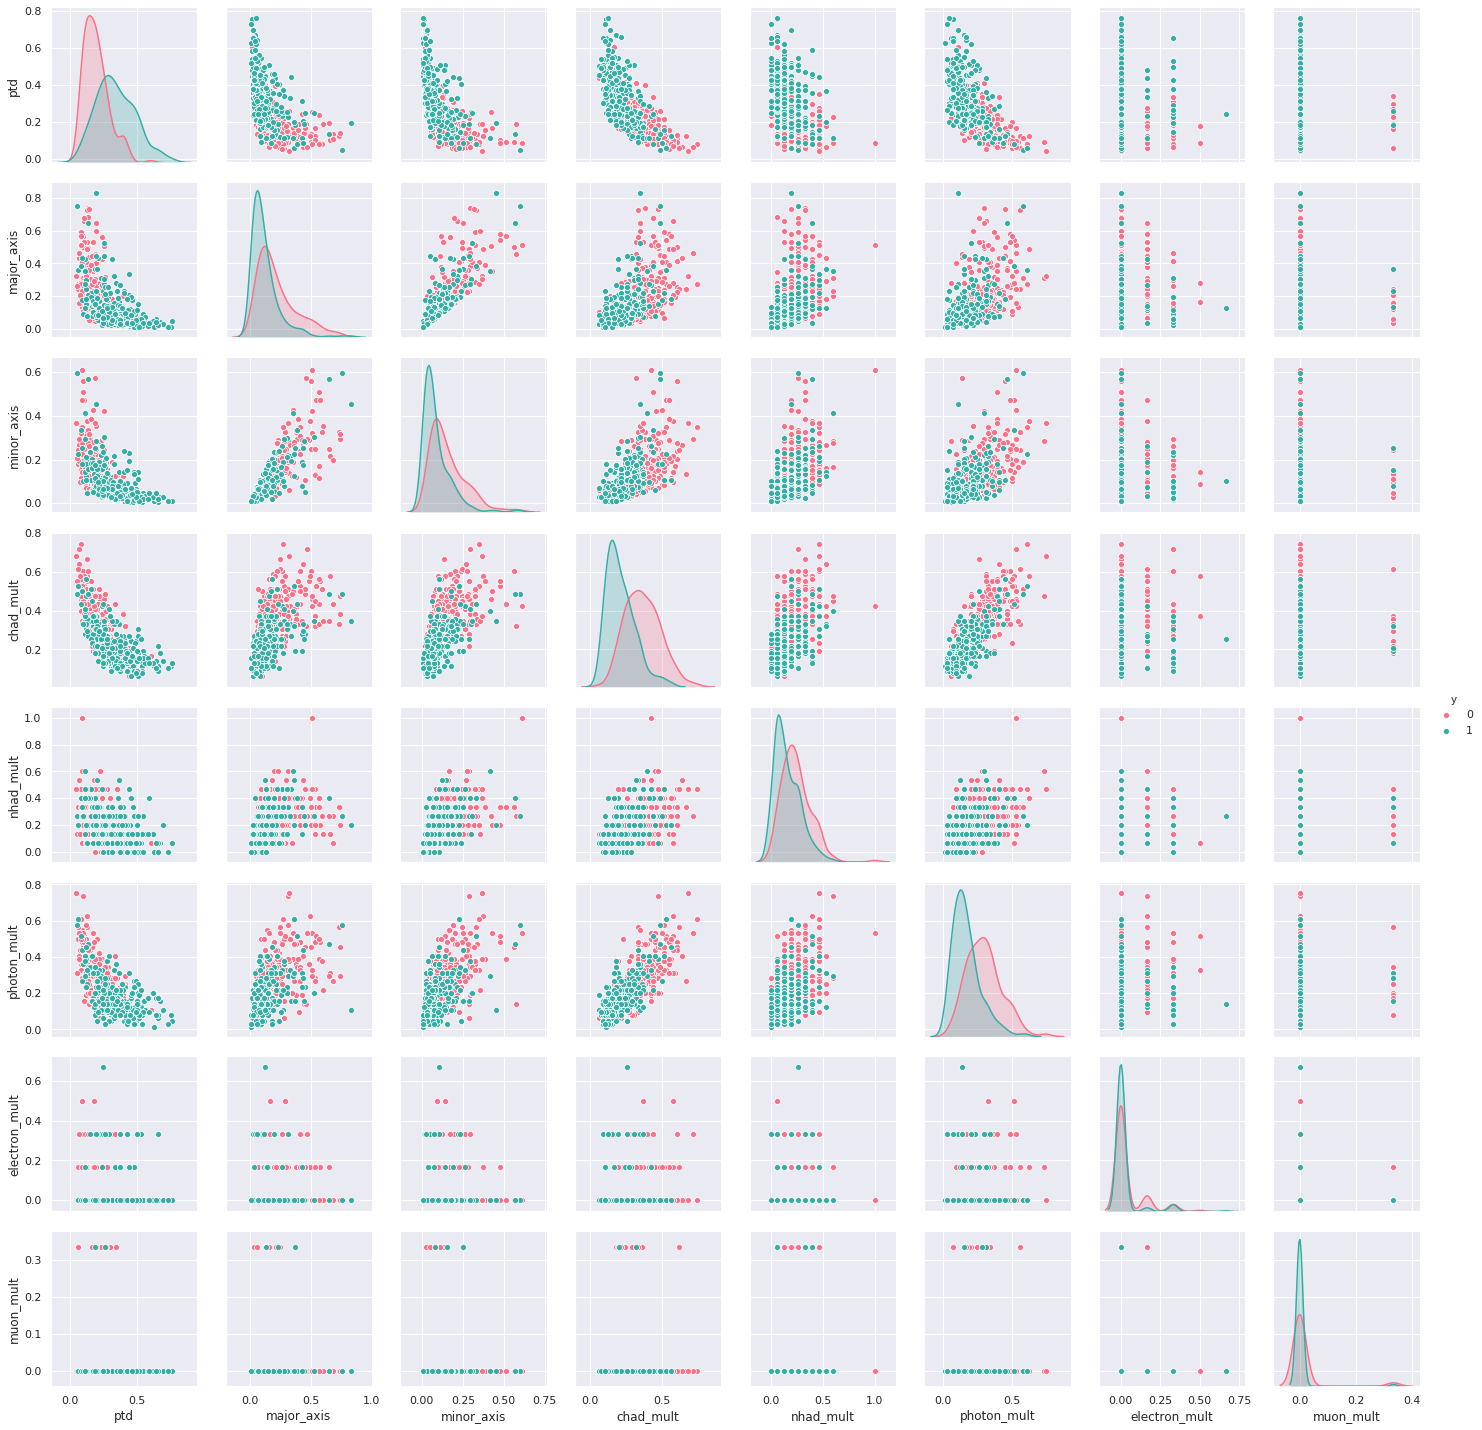

In [13]:
sns.pairplot(df, hue='y', vars=variables, palette="husl")

Text(0.5, 1.0, 't-SNE')

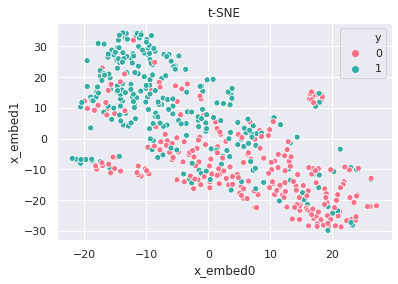

In [14]:
tsne = TSNE(random_state=random_state)
x_embed = tsne.fit_transform(x_vis)
df['x_embed0'] = x_embed[:, 0]
df['x_embed1'] = x_embed[:, 1]
ax = sns.scatterplot(data=df, x='x_embed0', y='x_embed1', hue='y', palette="husl")
ax.set_title("t-SNE")

In [15]:
def plot_learning_curve(history, title=None):
    kwargs = {'ls': '--', 'marker': 'o'}

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    axarr[0].plot(history.history['loss'], label='Training', **kwargs)
    axarr[0].plot(history.history['val_loss'], label="Validation", **kwargs)
    axarr[0].set_title("Loss")
    axarr[0].set_xlabel('Epoch')
    axarr[0].legend()

    axarr[1].plot(history.history['acc'], label='Training', **kwargs)
    axarr[1].plot(history.history['val_acc'], label="Validation", **kwargs)
    axarr[1].set_title("Accuracy")
    axarr[1].set_xlabel('Epoch')
    axarr[1].legend()
    
    if title is not None:
        fig.suptitle(title)

In [16]:
def run_experiment(model,
                   loss,
                   datasets,
                   title=None,
                   learning_rate=0.01,
                   epochs=100,
                   batch_size=256):
    
    model.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=loss,
        metrics=['accuracy'])

    history = model.fit(
        datasets.x_train,
        datasets.y_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(datasets.x_valid, datasets.y_valid),
        verbose=False)


    loss, acc = model.evaluate(datasets.x_test, datasets.y_test, verbose=False)
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    
    
    # plotting
    plot_learning_curve(history, title)
    
    return acc

# Deterministic Deep Model

In [17]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfkl.Dense(128),
    tfkl.ReLU(),
    tfkl.Dense(y_train.shape[-1]),
    tfkl.Softmax(),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0         
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________


W0805 09:36:10.322870 139835405428544 deprecation.py:323] From /home/slowmoyang/Installations/anaconda3/envs/py36-tf114/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Loss: 0.4821
Accuracy: 0.7707


0.77075

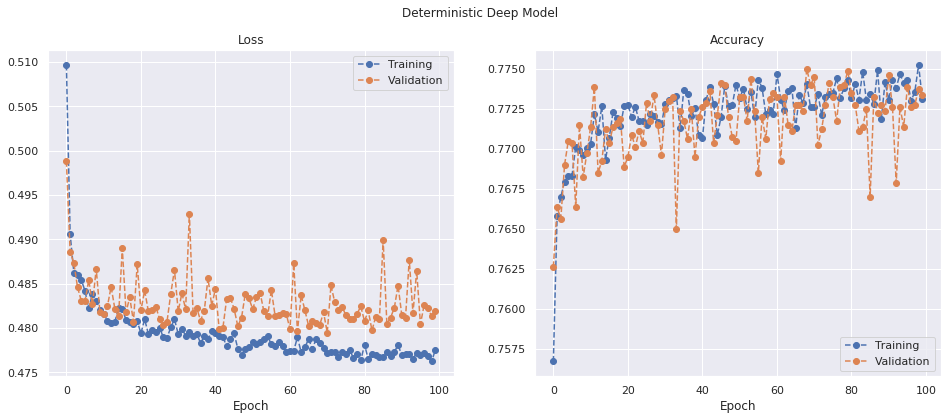

In [18]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    datasets=datasets,
    title='Deterministic Deep Model',
    learning_rate=0.01,
    epochs=100)

# Create probabilistic model
*  [Probabilistic Layer Regression](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
*  [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical)

In [19]:
kl_weight = 1 / len(x_train)
print(kl_weight)

4.1666666666666665e-05


In [20]:
def negative_log_likelihood(y_true, y_pred_rv):
    return -y_pred_rv.log_prob(y_true)

In [46]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    # NOTE When c = np.log(np.expm1(1.)), training is very unstable
    c = np.log(np.expm1(1.))
    # c = 0
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
  ])

In [47]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
    ])

In [48]:
def evaluate(model, x, y, num_monte_carlo=100):
    samples = tf.stack([model(x).probs for _ in range(num_monte_carlo)]).numpy()[:, :, 1]
    y_hat = samples.mean(axis=0)
    y = y[:, 1]
    accuracy = ((y_hat > 0.5).astype(int) == y).mean()
    print(f"Accuracy: {accuracy}")
    return accuracy

# Deep Bayesian Model

In [49]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfpl.DenseVariational(
        units=128,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfkl.ReLU(),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(y_train.shape[-1]) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(y_train.shape[-1]),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_2 (DenseVa (None, 128)               3456      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_variational_3 (DenseVa (None, 1)                 387       
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 2), (None, 2))    0         
Total params: 3,843
Trainable params: 3,843
Non-trainable params: 0
_________________________________________________________________


Loss: 0.4886
Accuracy: 0.6780
Accuracy: 0.769


0.769

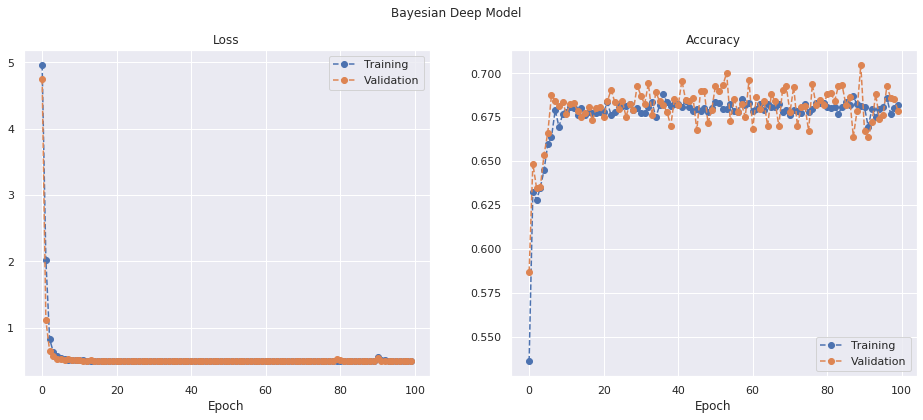

In [50]:
model.set_weights(initial_weights)

run_experiment(model,
               loss=negative_log_likelihood,
               datasets=datasets,
               title='Bayesian Deep Model',
               learning_rate=0.1,
               epochs=100)


evaluate(model, datasets.x_test, datasets.y_test)

# Uncertainty

In [51]:
num_monte_carlo = 100
prediction_samples = tf.stack([model(x_test).probs for _ in range(num_monte_carlo)]).numpy()

In [52]:
predictive_mean = prediction_samples[:, :, 1].mean(axis=0)
predictive_variance = prediction_samples[:, :, 1].var(axis=0)

(array([  48.,  131.,  218.,  309.,  340.,  467.,  256.,  391.,  689.,
        1173.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

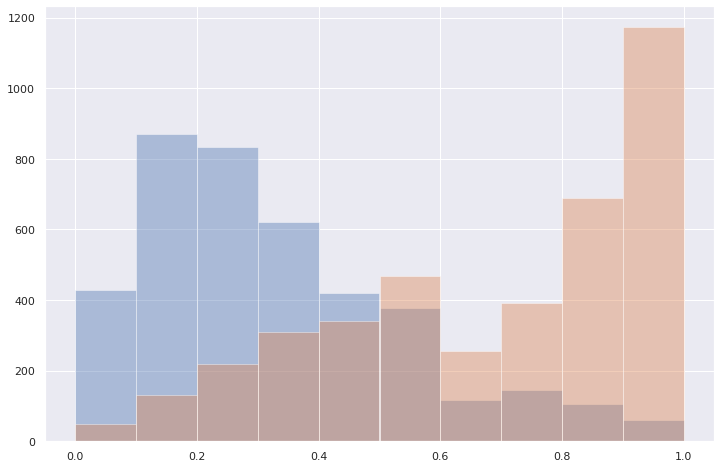

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(predictive_mean[y_test[:, 1] == 0], alpha=0.4, range=(0, 1))
ax.hist(predictive_mean[y_test[:, 1] == 1], alpha=0.4, range=(0, 1))

In [54]:
variation_ratio = compute_variation_ratio(prediction_samples)
predictive_entropy = compute_predictive_entropy(prediction_samples)
mutual_information = compute_mutual_information(prediction_samples)

In [55]:
def plot_uncertainty(mu, uncertainty, title=None):
    is_zero = y_test[:, 1] == 0
    is_one = y_test[:, 1] == 1
    
    fig, axarr = plt.subplots(ncols=2, figsize=(12, 6))
    axarr[0].scatter(mu[is_zero], uncertainty[is_zero], s=5, alpha=0.1)
    axarr[0].set_xlim(0, 1)
    axarr[1].scatter(mu[is_one], uncertainty[is_one], s=5, alpha=0.1)
    axarr[1].set_xlim(0, 1)
    
    if title is not None:
        fig.suptitle(title)

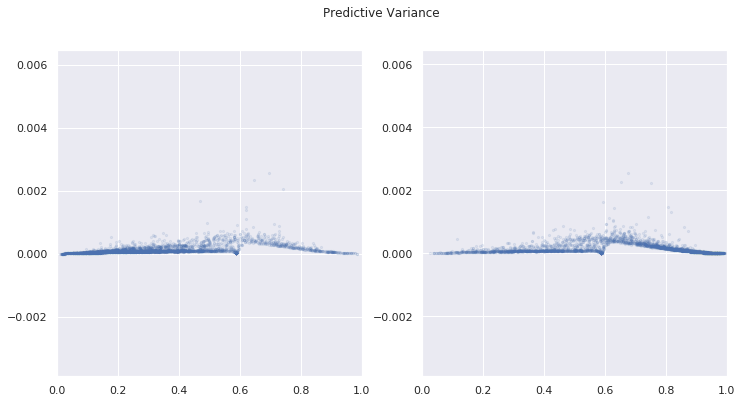

In [56]:
plot_uncertainty(predictive_mean, predictive_variance, title='Predictive Variance')

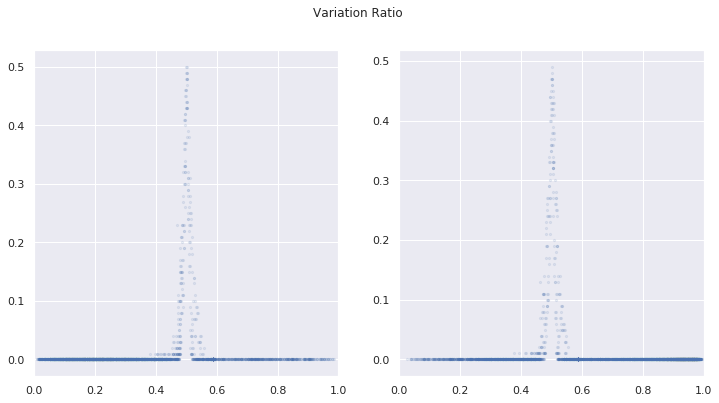

In [57]:
plot_uncertainty(predictive_mean, variation_ratio, title='Variation Ratio')

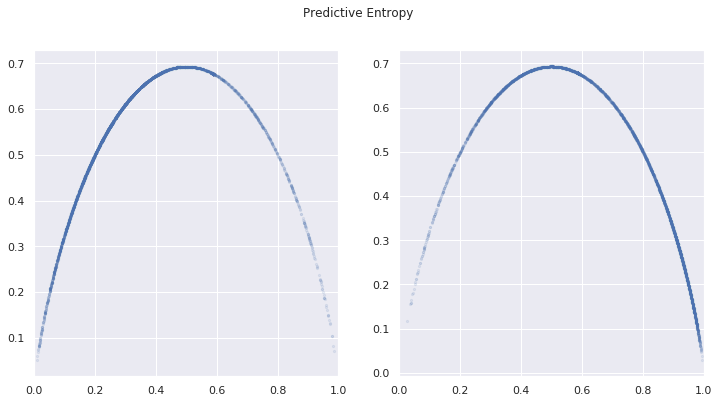

In [58]:
plot_uncertainty(predictive_mean, predictive_entropy, title="Predictive Entropy")

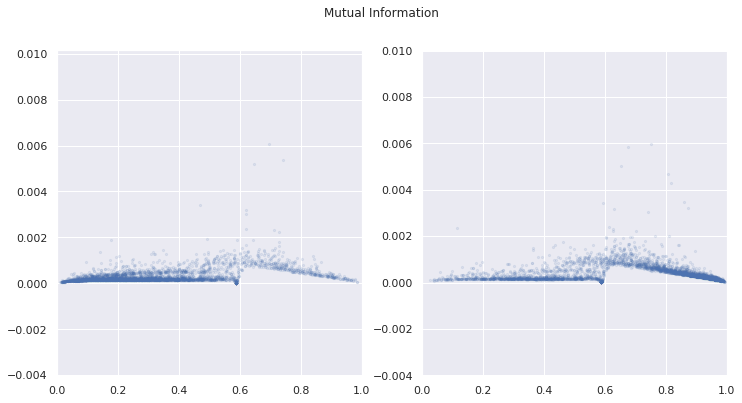

In [59]:
plot_uncertainty(predictive_mean, mutual_information, title="Mutual Information")

In [60]:
y_pred = predictive_mean > 0.5
y_true = y_test[..., 1]

In [61]:
def draw_uncertainty(y_true, y_pred,
                     uncertainty,
                     uncertainty_name,
                     title, log=False):
    
    is_sig = y_true == 1
    is_bkg = y_true == 0

    is_true_pos = np.logical_and(is_sig, y_pred == 1)
    is_false_neg = np.logical_and(is_sig, y_pred == 0)

    is_true_neg = np.logical_and(is_bkg, y_pred == 0)
    is_false_pos = np.logical_and(is_bkg, y_pred == 1)
    
    
    signal = [
        uncertainty[is_true_pos],
        uncertainty[is_false_neg]
    ]

    background = [
        uncertainty[is_true_neg],
        uncertainty[is_false_pos]
    ]

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    suptitle = fig.suptitle(title, fontsize="x-large")

    signal_hists, _, _ = axarr[0].hist(
        signal,
        label=["signal (Correct)", "signal (Incorrect)"],
        color=['skyblue', 'b'],
        stacked=True, bins=50, alpha=0.3)

    background_hists, _, _ = axarr[1].hist(
        background,
        label=["background (Correct)", "background (Incorrect)"],
        color=['lightcoral', 'r'],
        stacked=True, bins=50, alpha=0.5)

    max_value = max(each.max() for each in signal_hists + background_hists)
    y_max = 1.05 * max_value

    for ax in axarr:
        ax.grid()
        ax.legend(fontsize=15)
        ax.set_xlabel(uncertainty_name)
        if log:
            ax.set_yscale('log')

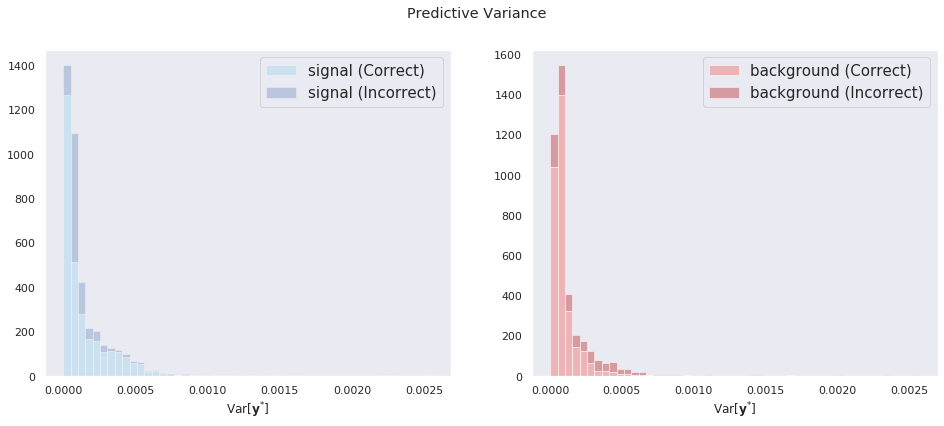

In [62]:
draw_uncertainty(y_true, y_pred, predictive_variance, r'Var$[ \mathbf{y}^{*}]$', 'Predictive Variance')

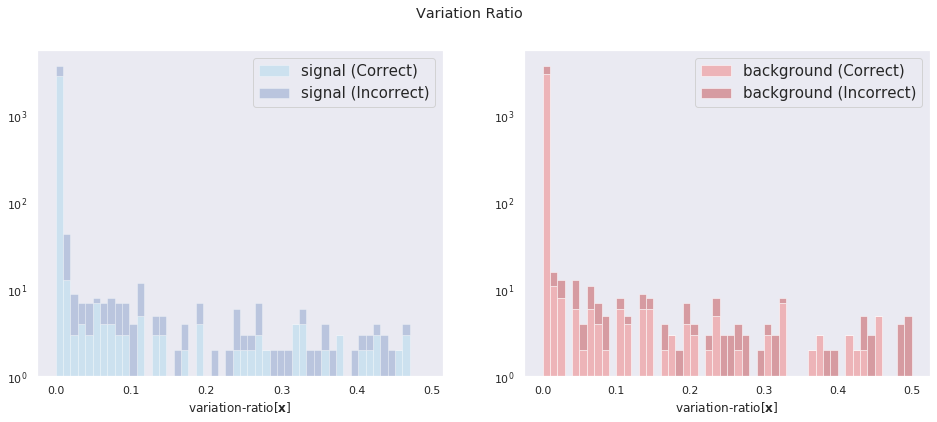

In [63]:
draw_uncertainty(y_true, y_pred, variation_ratio, r'variation-ratio[$\mathbf{x}$]', 'Variation Ratio', True)

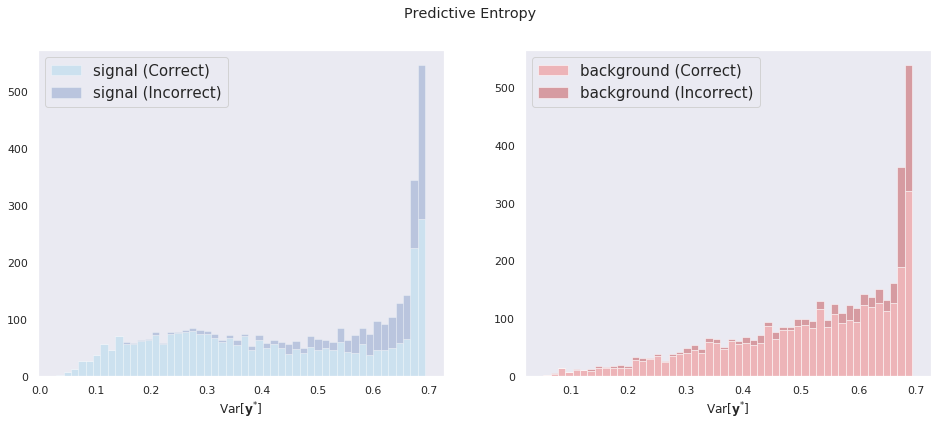

In [64]:
draw_uncertainty(y_true, y_pred, predictive_entropy, r'Var$[ \mathbf{y}^{*}]$', 'Predictive Entropy')

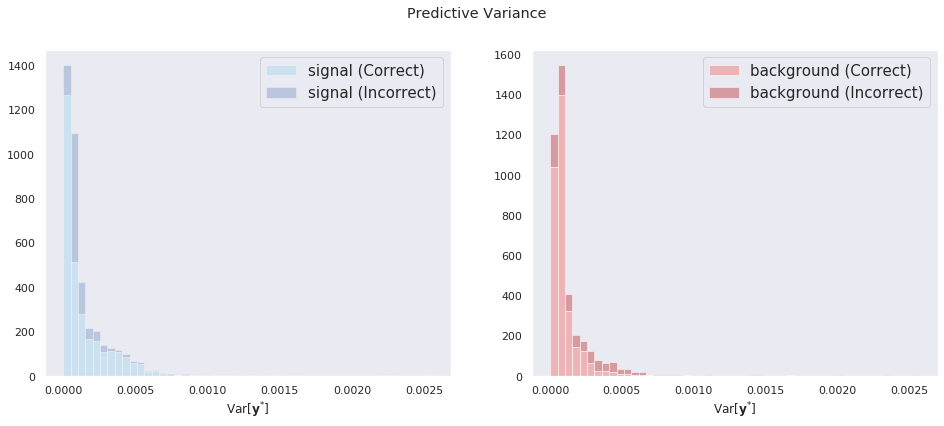

In [65]:
draw_uncertainty(y_true, y_pred, predictive_variance, r'Var$[ \mathbf{y}^{*}]$', 'Predictive Variance')

# Signal Efficiency vs Significance

In [66]:
def draw_curve(y_true, y_pred,
               uncertainty,
               title):
    
    is_sig = y_true == 1
    is_bkg = y_true == 0

    is_true_pos = np.logical_and(is_sig, y_pred == 1)
    is_false_neg = np.logical_and(is_sig, y_pred == 0)

    is_true_neg = np.logical_and(is_bkg, y_pred == 0)
    is_false_pos = np.logical_and(is_bkg, y_pred == 1)
    
    
    signal_efficiency = []
    background_efficiency = []
    for cut in np.linspace(uncertainty.min(), uncertainty.max()):
        good = uncertainty < cut
        
        if sum(good) == 0:
            continue
        
        sig_eff = sum(is_true_pos[good]) / sum(is_sig)
        bkg_eff = sum(is_false_pos[good]) / sum(is_bkg)
        
        signal_efficiency.append(sig_eff)
        background_efficiency.append(bkg_eff)

    sig_eff = np.array(signal_efficiency)
    bkg_eff = np.array(background_efficiency)

    fig, ax = plt.subplots(figsize=(6, 4))
    suptitle = fig.suptitle(title, fontsize="x-large")

    # NOTE
    safe_idx = bkg_eff.nonzero()
    bkg_eff = bkg_eff[safe_idx]
    sig_eff = sig_eff[safe_idx]

    inv_sqrt_bkg_eff = 1 / np.sqrt(bkg_eff)
    line1 = ax.plot(sig_eff, inv_sqrt_bkg_eff,
                    marker="o", ls="--", color="mediumorchid",
                    label=r"$1 / \sqrt{\epsilon_{B}}$")
    ax.set_xlabel(r"$\epsilon_{S}$", fontdict={'size': 20})
    ax.set_ylabel(r"$1 / \sqrt{\epsilon_{B}}$", fontdict={'size': 20})
    # ax.grid()

    # NOTE
    twinx = ax.twinx()

    significance = sig_eff / np.sqrt(bkg_eff)
    line2 = twinx.plot(sig_eff, significance,
                       marker="^", ls="--", color="darkgreen",
                       label=r"$\epsilon_{S} / \sqrt{\epsilon_{B}}$")
    twinx.set_xlabel(r"$\epsilon_{S}$", fontdict={'size': 20})
    twinx.set_ylabel(r"$\epsilon_{S} / \sqrt{\epsilon_{B}}$", fontdict={'size': 20})
    # twinx.grid()

    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, fontsize=20, loc='center right')

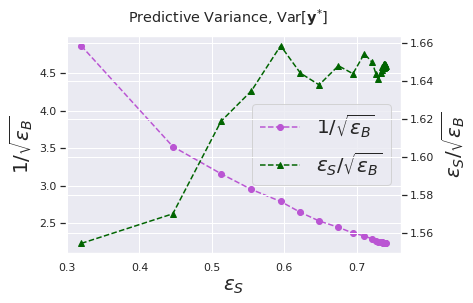

In [67]:
draw_curve(y_true, y_pred, predictive_variance, r'Predictive Variance, Var$[\mathbf{y}^{*}]$')

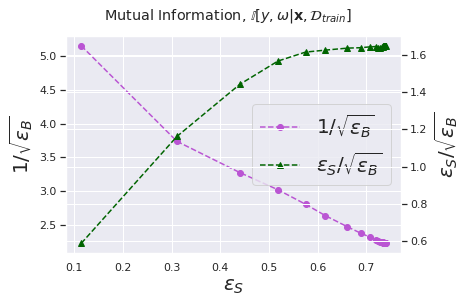

In [68]:
draw_curve(y_true, y_pred, mutual_information,
           r'Mutual Information, $ \mathbb{I}[y,\omega|\mathbf{x},\mathcal{D}_{train}]$')

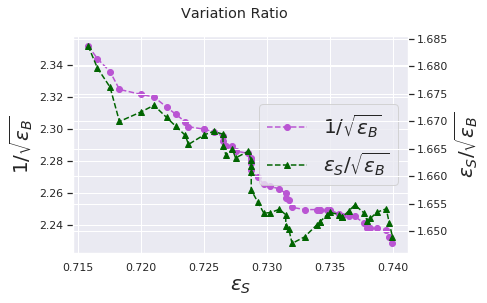

In [69]:
draw_curve(y_true, y_pred, variation_ratio, 'Variation Ratio')

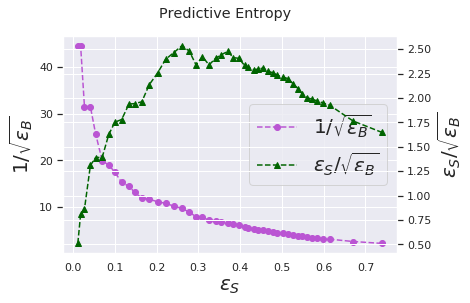

In [70]:
draw_curve(y_true, y_pred, predictive_entropy, 'Predictive Entropy')